Note that with the code above one cannot directly input a video and receive a classification label of compressed or double compressed. This could be achieved by saving a preffered model (python pickle). After a new video is given by the user, features can be extracted and summarized as below for classification. 

# Press play cell button to run the H.264 classification pipeline

running everything will take about 10 minutes (copies data from github, builds a classifier, tests over more runs, makes some exploratory and summarization plots)

In [ ]:
!pip install -q gitpython
!pip install seaborn
import os
import pandas as pd
from git import Repo

# Clone the GitHub repository
repo_url = 'https://github.com/c1scott/doublecompression'
repo_path = 'doublecompression'
Repo.clone_from(repo_url, repo_path)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<git.repo.base.Repo '/content/doublecompression/.git'>

In [ ]:
def extract_feature_counts(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    feature_counts = {}
    for line in lines:
        if line.startswith('#'):
            continue
        try:
            key, value = line.strip().split(': ')
            feature_counts[key] = int(value)
        except ValueError:
            print(f"Warning: invalid line format in file {file_path}: {line.strip()}")

    return feature_counts

# define folder paths
folder_paths = [
    (os.path.join(repo_path, '/content/doublecompression/token_counts_originals_set2'), 'originals'),
    (os.path.join(repo_path, '/content/doublecompression/token_counts_compressed_videos'), 'compressed')
]

# extract feature counts and class labels for all text files in both folders
data = []
for folder_path, folder_class in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt') or filename.endswith('_mb_tokens.txt') or filename.endswith('_compressed_tokens.txt'):
            file_path = os.path.join(folder_path, filename)
            feature_counts = extract_feature_counts(file_path)
            data_point = (feature_counts, folder_class)
            data.append(data_point)

# convert the data into a pandas DataFrame
data = pd.DataFrame(data, columns=['feature_counts', 'class_label'])

Show the structure of the data imported

In [ ]:
data.head()


,feature_counts,class_label
0,"{'P': 2277, 'A': 544, 'i': 5161999, 'I': 35098...",originals
1,"{'P': 2421, 'A': 550, 'i': 4923569, 'I': 28456...",originals
2,"{'P': 1941, 'A': 568, 'i': 3541441, 'I': 16438...",originals
3,"{'P': 1447, 'A': 640, 'i': 2228113, 'I': 13848...",originals
4,"{'P': 1759, 'A': 276, 'i': 845025, 'I': 636538...",originals


Display the number of files per each class

In [ ]:
class_counts = data['class_label'].value_counts()
print(class_counts)


originals     34
compressed    34
Name: class_label, dtype: int64


This code trains a Random Forest classifier on the feature counts extracted from two sets of videos (originals and compressed). The data is split into training, validation, and testing sets, and a DictVectorizer is used to transform the dictionaries into feature matrices. The RandomForestClassifier is then trained on the transformed training set and evaluated on the validation set using classification_report. Finally, the model is evaluated on the testing set using classification_report.

Run 1/50
F1-score on testing set: 0.929
Best hyperparameters found by grid search: {'svm__C': 10.0, 'svm__gamma': 0.01}

Run 2/50
F1-score on testing set: 0.931
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.01}

Run 3/50
F1-score on testing set: 0.857
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 4/50
F1-score on testing set: 0.860
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.01}

Run 5/50
F1-score on testing set: 0.930
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.01}

Run 6/50
F1-score on testing set: 0.931
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.01}

Run 7/50
F1-score on testing set: 0.929
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.01}

Run 8/50
F1-score on testing set: 0.851
Best hyperparameters found by grid search: {'svm__C': 1000.0, 'svm__gamma': 0.01}

Run 9/50
F1-score on te

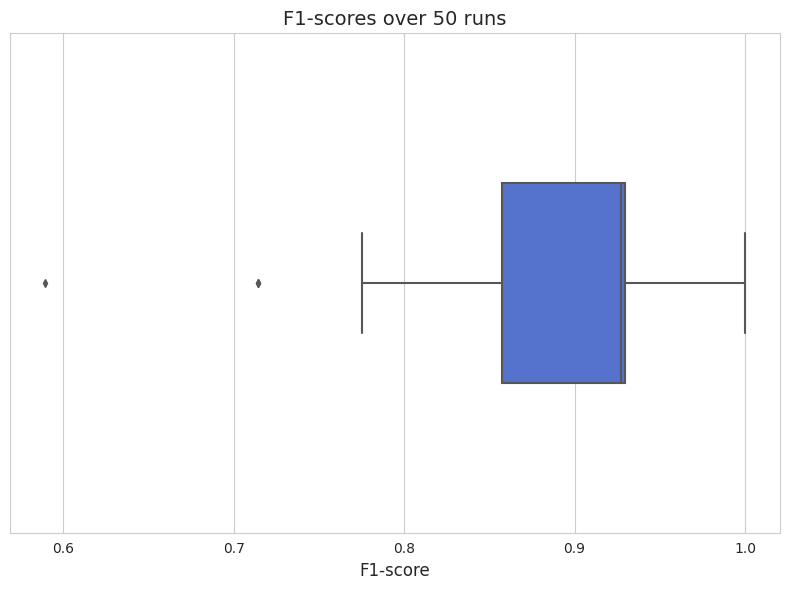

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

# Define the hyperparameters to search over
param_grid = {
    'svm__C': np.logspace(-3, 3, 7),
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-4, 2, 7))
}

# Create a pipeline with feature extraction, normalization, and model training steps
pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

# Use a stratified KFold cross-validation for better model evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []

for i in range(50):
    print(f"Run {i+1}/50")
    # Split data into training and testing sets randomly
    X_train, X_test, y_train, y_test = train_test_split(data['feature_counts'], data['class_label'], test_size=0.2, random_state=i)

    # Perform a grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Train the SVM with the best hyperparameters found by the grid search
    clf = grid_search.best_estimator_

    # Make predictions on the testing set
    y_pred_test = clf.predict(X_test)

    # Evaluate the model on testing set
    f1_score_test = classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['f1-score']

    f1_scores.append(f1_score_test)

    print(f"F1-score on testing set: {f1_score_test:.3f}")
    print(f"Best hyperparameters found by grid search: {grid_search.best_params_}")
    print()

# Plot the F1-scores over the 50 runs as a box plot
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.boxplot(x=f1_scores, color='royalblue', width=0.4, fliersize=4)
plt.title('F1-scores over 50 runs', fontsize=14)
plt.xlabel('F1-score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1-score over 50 runs: {mean_f1_score:.3f}")


Mean F1-score over 50 runs: 0.892


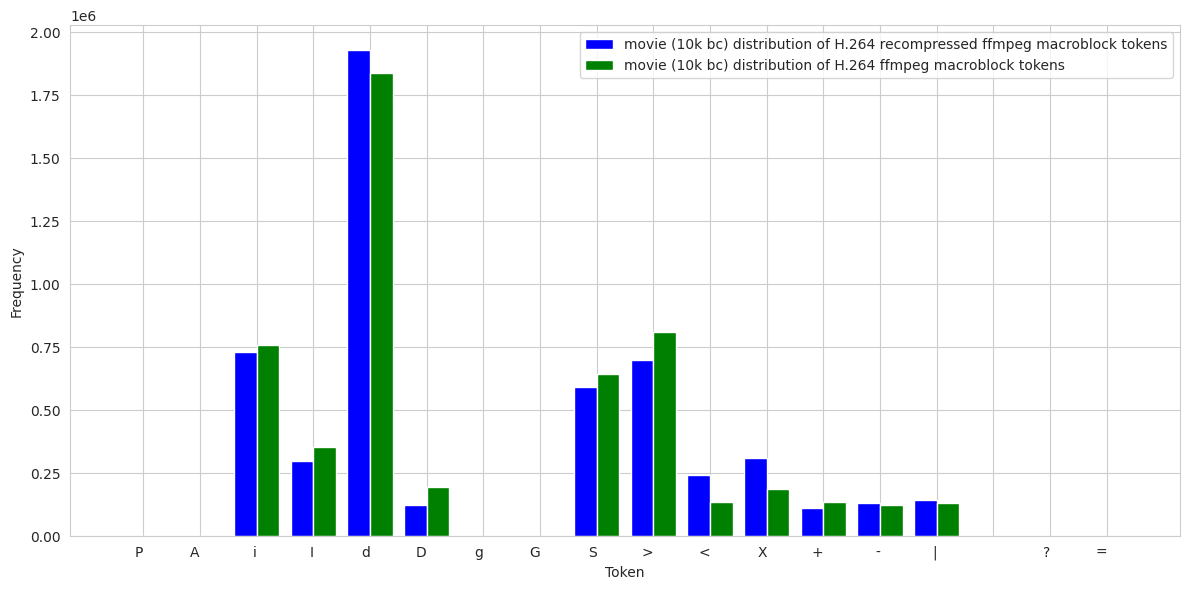

In [ ]:
import matplotlib.pyplot as plt

def read_token_counts(file_path):
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()

    tokens, counts = [], []
    for line in lines:
        token, count = line.split(': ')
        tokens.append(token)
        counts.append(int(count))
    
    return tokens, counts

file1_path = '/content/doublecompression/token_counts_compressed_videos/token_counts_10,000 B.C. - Teaser_compressed_tokens.txt'
file2_path = '/content/doublecompression/token_counts_originals_set2/token_counts_10,00_mb_tokens.txt'

tokens1, counts1 = read_token_counts(file1_path)
tokens2, counts2 = read_token_counts(file2_path)

fig, ax = plt.subplots(figsize=(12, 6))

width = 0.4
x1 = [i - width/2 for i in range(len(tokens1))]
x2 = [i + width/2 for i in range(len(tokens2))]

ax.bar(x1, counts1, width=width, align='center', color='blue', label='movie (10k bc) distribution of H.264 recompressed ffmpeg macroblock tokens')
ax.bar(x2, counts2, width=width, align='center', color='green', label='movie (10k bc) distribution of H.264 ffmpeg macroblock tokens')

ax.set_xticks(range(len(tokens1)))
ax.set_xticklabels(tokens1, ha='right')

ax.set_xlabel('Token')
ax.set_ylabel('Frequency')

ax.legend()

plt.tight_layout()
plt.show()


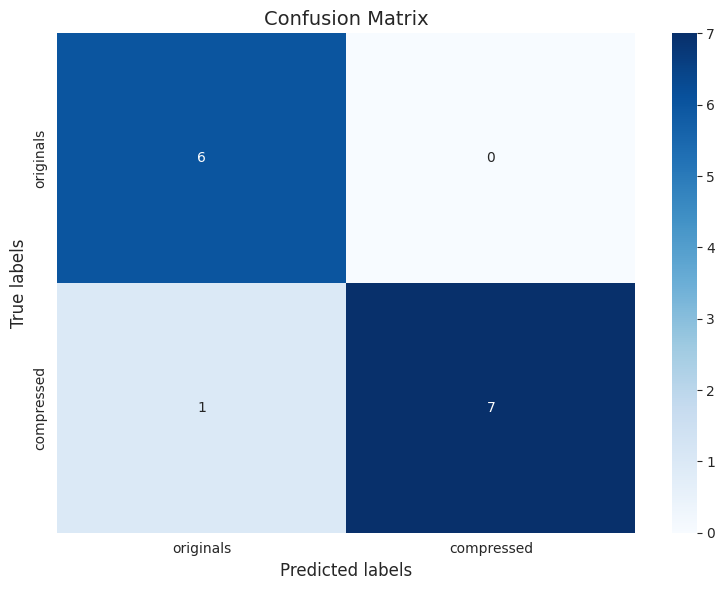

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_test)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['originals', 'compressed'], yticklabels=['originals', 'compressed'])
plt.xlabel('Predicted labels', fontsize=12)
plt.ylabel('True labels', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()


running everything will take about 10-15 minutes (copies data from github, builds a classifier, tests over more runs, makes some exploratory and summarization plots)

# Code below for reference purposes (contains extraction of features from videos)

 A Python script that compresses video files in a given input folder and saves the compressed files in a specified output folder. The script uses the FFmpeg command-line tool to perform the compression. It supports various video file formats, such as MP4, AVI, MOV, MKV, and WMV. The compression settings include the libx264 video codec, a Constant Rate Factor (CRF) of 5 for high-quality output, a slow encoding speed for better compression ratio, and the AAC audio codec with a bitrate of 128 kbps.

In [ ]:
# Import necessary libraries
import os
import subprocess
from pathlib import Path

# Set the input and output folder paths
input_folder = Path('C:/Users/q42/Downloads/clips trailers h264/clips2/data2/trailers original')
output_folder = Path('C:/Users/q42/Downloads/clips trailers h264/clips2/data2/slowcrf5')

# Create the output folder if it doesn't exist
output_folder.mkdir(parents=True, exist_ok=True)

# List of supported video file extensions
video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.wmv']

# Iterate through files in the input folder
for filename in input_folder.iterdir():
    # Check if the file has a supported video extension
    if filename.suffix.lower() in video_extensions:
        # Set the input and output file paths
        input_path = filename
        output_path = output_folder / f"{filename.stem}_compressed.mp4"
        
        # Create the command to compress the video using FFmpeg
        command = [
            "ffmpeg",
            "-i", str(input_path),                # Input file path
            "-c:v", "libx264",                    # Video codec
            "-crf", "5",                          # Constant Rate Factor (lower value = higher quality)
            "-preset", "slow",                    # Encoding speed and compression ratio
            "-c:a", "aac",                        # Audio codec
            "-b:a", "128k",                       # Audio bitrate
            str(output_path)                      # Output file path
        ]
        
        # Run the FFmpeg command to compress the video
        subprocess.run(command)


In [ ]:
# Using the below, one can extract macroblocks data from the files and output them into a new folder

import os
import glob
import subprocess

input_folder = 'C:/Users/q42/Downloads/clips trailers h264/clips2/data2/trailers original'
output_folder = 'C:/Users/q42/Downloads/clips trailers h264/clips2/data2/trailers original'

for video_file in glob.glob(os.path.join(input_folder, "*.mp4")):
    # Get the base file name without the extension
    base_file_name = os.path.splitext(os.path.basename(video_file))[0]
    # Create the output text file paths
    if base_file_name.endswith("_compressed"):
        output_path = os.path.join(output_folder, base_file_name + ".txt")
    else:
        output_path = os.path.join(output_folder, base_file_name[:5] + "_mb.txt")

    # Extract macroblock information to a text file
    extract_mb_command = ["ffmpeg", "-threads", "8", "-debug", "mb_type", "-i", video_file, "-f", "null", "-"]

    with open(output_path, "w") as output_file:
        subprocess.call(extract_mb_command, stdout=output_file, stderr=subprocess.STDOUT)

    # Print a message indicating that the file was processed
    print(f"Macroblock data extracted for {video_file} and saved to {output_path}")


These are the indicators used in a macroblock (a square block of pixels in a video compression algorithm) in the H.264 video coding standard to represent different coding modes and other information.

The mb_outputs list contains indicators for different coding modes, such as intra-coding, direct-coded, and inter-coded macroblocks.

The segmentation_indicators list contains indicators for different types of macroblock segmentation, which is a technique for dividing a macroblock into smaller blocks to improve compression efficiency.

The interlace_indicators list contains indicators for whether a macroblock is interlaced, which means that the picture is split into two fields that are captured and transmitted at different times and then combined to form a complete picture.

In [ ]:
# These are from https://github.com/FFmpeg/FFmpeg/blob/918de766f545008cb1ab3d62febe71fa064f8ca7/libavcodec/mpegutils.c#L212

mb_outputs = [
    'P',  # PCM
    'A',  # intra-coded macroblocks with AC prediction
    'i',  # intra-coded 4x4 macroblocks
    'I',  # intra-coded 16x16 macroblocks
    'd',  # direct-coded macroblocks with skip
    'D',  # direct-coded macroblocks without skip
    'g',  # GMC-coded macroblocks with skip
    'G',  # GMC-coded macroblocks without skip
    'S',  # skipped macroblocks
    '>',  # inter-coded macroblocks that use list 0 only
    '<',  # inter-coded macroblocks that use list 1 only
    'X'   # inter-coded macroblocks that use both lists 0 and 1
]

segmentation_indicators = [
    '+',  # macroblocks using 8x8 segmentation
    '-',  # macroblocks using 16x8 segmentation
    '|',  # macroblocks using 8x16 segmentation
    ' ',  # macroblocks using 16x16 segmentation or intra-coding
    '?'   # macroblocks with unknown segmentation
]

interlace_indicators = [
    '=',  # interlaced macroblocks
    ' '   # non-interlaced macroblocks
]

This code tokenizes the contents of text files containing macroblock data from H.264 video coding, and writes the resulting tokens to new text files in a specified output folder.

The code first defines input and output folder paths. It then combines all tokenizing characters (i.e., the mb_outputs, segmentation_indicators, and interlace_indicators lists) into a single list.

A regular expression pattern is then constructed using the pattern variable, which matches any of the tokenizing characters when they are not surrounded by word characters. This pattern is used to split the contents of each input file into tokens using the re.split() function.

The resulting tokens are then filtered to remove any empty tokens, tokens consisting only of whitespace, and tokens longer than one character. The remaining tokens are written to a new output file in the specified output folder, with the same name as the input file but with a suffix of "_tokens.txt".

In [ ]:
import os
import re

def read_input_file(input_file):
    with open(input_file, 'r') as f:
        content = f.read()
    return content

# define folder paths
input_folder_path = 'C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/'
output_folder_path = 'C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens/'

# combine all tokenizing characters 
token_chars = mb_outputs + segmentation_indicators + interlace_indicators

# regex pattern for tokenizing
pattern = rf'(?<!\w)([{"|".join(re.escape(c) for c in token_chars)}])(?!\w)'

# iterate over all files in input folder
for filename in os.listdir(input_folder_path):
    if filename.endswith(".txt"): # consider only .txt files
        input_file = os.path.join(input_folder_path, filename)
        tokens = re.split(pattern, read_input_file(input_file))
        tokens = [t for t in tokens if t and not t.isspace() and len(t)==1]
        
        # rename input file to output file with suffix '_tokens'
        output_file = os.path.join(output_folder_path, filename.replace('.txt', '_tokens.txt'))
        with open(output_file, 'w') as f:
            f.write('\n'.join(tokens))
        
        print(f"Finished processing {filename}. Output written to {output_file}.")


Finished processing The Town - International Trailer_compressed.txt. Output written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens/The Town - International Trailer_compressed_tokens.txt.
Finished processing Thor - Trailer_compressed.txt. Output written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens/Thor - Trailer_compressed_tokens.txt.
Finished processing Tron Legacy - Trailer_compressed.txt. Output written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens/Tron Legacy - Trailer_compressed_tokens.txt.
Finished processing Valkyrie - Trailer 3_compressed.txt. Output written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens/Valkyrie - Trailer 3_compressed_tokens.txt.
Finished processing Warm Bodies - Trailer_compressed.txt. Output written to C:/Users/q42/Downloads/cli

The code counts the occurrences of each token in the tokenized macroblock data files generated by a previous code and writes the results to new text files in a folder called "token_counts". It defines the folder path containing the input files, creates a new folder for output files, and iterates over all input files in the folder that end in "_tokens.txt". For each input file, it counts the occurrences of each token using a dictionary and writes the counts to a new output file in the "token_counts" folder. Finally, it prints a message indicating that the processing is complete for each input file.

In [ ]:
# Token counter 

import os

def count_token_occurrences(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    # split the file content by spaces or newlines
    tokens = content.split()

    counts = {t: 0 for t in mb_outputs + segmentation_indicators + interlace_indicators}
    for t in tokens:
        if t in counts:
            counts[t] += 1

    return counts

def write_token_counts(file_path, counts):
    with open(file_path, 'w') as f:
        for token, count in counts.items():
            f.write(f"{token}: {count}\n")

# define folder path
folder_path = 'C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens' 

# create new folder for output files
output_folder = os.path.join(folder_path, 'token_counts')
os.makedirs(output_folder, exist_ok=True)

# iterate over all files in folder that end in '_mb_tokens.txt' or '_compressed.txt'
for filename in os.listdir(folder_path):
    if filename.endswith("_tokens.txt"):
        input_file = os.path.join(folder_path, filename)
        counts = count_token_occurrences(input_file)
        
        # write counts to a new file in the 'token_counts' folder
        output_file = os.path.join(output_folder, f"token_counts_{filename}")
        write_token_counts(output_file, counts)

        print(f"Processed {filename}. Counts written to {output_file}.")

Processed 10,000 B.C. - Teaser_compressed_tokens.txt. Counts written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens\token_counts\token_counts_10,000 B.C. - Teaser_compressed_tokens.txt.
Processed Angels & Demons - Trailer_compressed_tokens.txt. Counts written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens\token_counts\token_counts_Angels & Demons - Trailer_compressed_tokens.txt.
Processed Black Swan - Trailer_compressed_tokens.txt. Counts written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens\token_counts\token_counts_Black Swan - Trailer_compressed_tokens.txt.
Processed Brave - Trailer_compressed_tokens.txt. Counts written to C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/compressed_tokens\token_counts\token_counts_Brave - Trailer_compressed_tokens.txt.
Processed District 9 - T

This code extracts feature counts and class labels from text files in two folders named 'originals' and 'compressed'. The 'extract_feature_counts' function reads a text file and returns a dictionary of feature counts. The 'data' list is used to store tuples of feature counts and class labels extracted from the text files in the two folders. Finally, the 'data' list is converted into a pandas DataFrame named 'data' with two columns, 'feature_counts' and 'class_label'.

In [ ]:
import os
import pandas as pd

def extract_feature_counts(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    feature_counts = {}
    for line in lines:
        if line.startswith('#'):
            continue
        try:
            key, value = line.strip().split(': ')
            feature_counts[key] = int(value)
        except ValueError:
            print(f"Warning: invalid line format in file {file_path}: {line.strip()}")

    return feature_counts


# define folder paths
folder_paths = [
    ('C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/token_counts_originals_set2', 'originals'),
    ('C:/Users/q42/Downloads/clips trailers h264/clips2/data2/mediumcrf10/macroblocksdata/token_counts_compressed_videos', 'compressed')
]

# extract feature counts and class labels for all text files in both folders
data = []
for folder_path, folder_class in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt') or filename.endswith('_mb_tokens.txt') or filename.endswith('_compressed_tokens.txt'):
            file_path = os.path.join(folder_path, filename)
            feature_counts = extract_feature_counts(file_path)
            data_point = (feature_counts, folder_class)
            data.append(data_point)

# convert the data into a pandas DataFrame
data = pd.DataFrame(data, columns=['feature_counts', 'class_label'])


In [ ]:
data.head()

,feature_counts,class_label
0,"{'P': 855, 'A': 138, 'i': 760085, 'I': 354906,...",originals
1,"{'P': 1777, 'A': 502, 'i': 4144845, 'I': 30177...",originals
2,"{'P': 1835, 'A': 476, 'i': 3736536, 'I': 16249...",originals
3,"{'P': 1234, 'A': 460, 'i': 2226147, 'I': 72111...",originals
4,"{'P': 1726, 'A': 314, 'i': 2719016, 'I': 76587...",originals


In [ ]:
class_counts = data['class_label'].value_counts()
print(class_counts)


originals     34
compressed    34
Name: class_label, dtype: int64


This code trains a Random Forest classifier on the feature counts extracted from two sets of videos (originals and compressed). The data is split into training, validation, and testing sets, and a DictVectorizer is used to transform the dictionaries into feature matrices. The RandomForestClassifier is then trained on the transformed training set and evaluated on the validation set using classification_report. Finally, the model is evaluated on the testing set using classification_report.

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Split data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(data['feature_counts'], data['class_label'], test_size=0.2, random_state=42)

# Split training set into new training set and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Transform dictionaries into feature matrix
vectorizer = DictVectorizer(sparse=False)
X_train_transformed = vectorizer.fit_transform(X_train)
X_valid_transformed = vectorizer.transform(X_valid)
X_test_transformed = vectorizer.transform(X_test)

# Train the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_transformed, y_train)

# Make predictions
y_pred = clf.predict(X_valid_transformed)

# Evaluate the model on validation set
print(classification_report(y_valid, y_pred))

# Make predictions on the testing set
y_pred_test = clf.predict(X_test_transformed)

# Evaluate the model on testing set
print(classification_report(y_test, y_pred_test))


              precision    recall  f1-score   support

  compressed       0.88      1.00      0.93         7
   originals       1.00      0.75      0.86         4

    accuracy                           0.91        11
   macro avg       0.94      0.88      0.90        11
weighted avg       0.92      0.91      0.91        11

              precision    recall  f1-score   support

  compressed       0.75      1.00      0.86         6
   originals       1.00      0.75      0.86         8

    accuracy                           0.86        14
   macro avg       0.88      0.88      0.86        14
weighted avg       0.89      0.86      0.86        14



This code trains and evaluates an SVM model using feature extraction, normalization, and cross-validation.

First, a pipeline is defined with three steps: vectorizing the input features using the DictVectorizer, scaling the resulting feature matrix using StandardScaler, and training an SVM classifier with a radial basis function kernel.

Then, the script uses stratified 5-fold cross-validation to train and evaluate the model 50 times, each time with a different random seed. The dataset is split into training and testing sets using train_test_split(), and the best hyperparameters for the SVM are determined using GridSearchCV. The best estimator is then used to make predictions on the testing set, and the F1-score is computed using classification_report(). The F1-scores from each run are appended to a list and the average F1-score over all runs is printed at the end.

In [ ]:
pip install seaborn

Run 1/50
F1-score on testing set: 0.929
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 2/50
F1-score on testing set: 0.931
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 3/50
F1-score on testing set: 0.927
Best hyperparameters found by grid search: {'svm__C': 1000.0, 'svm__gamma': 0.001}

Run 4/50
F1-score on testing set: 0.926
Best hyperparameters found by grid search: {'svm__C': 1000.0, 'svm__gamma': 0.001}

Run 5/50
F1-score on testing set: 0.789
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 6/50
F1-score on testing set: 0.931
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.01}

Run 7/50
F1-score on testing set: 0.787
Best hyperparameters found by grid search: {'svm__C': 1000.0, 'svm__gamma': 0.0001}

Run 8/50
F1-score on testing set: 0.714
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 9/50
F1-s

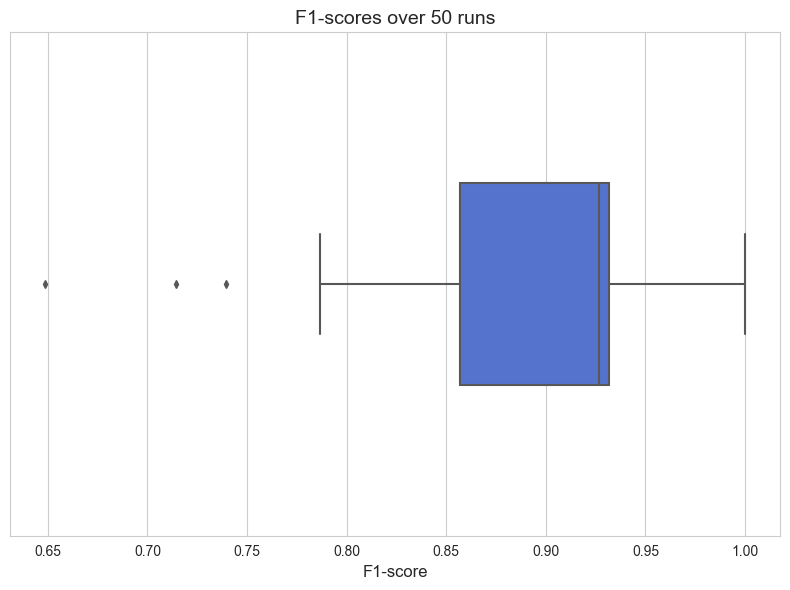

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the hyperparameters to search over
param_grid = {
    'svm__C': np.logspace(-3, 3, 7),
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-4, 2, 7))
}

# Create a pipeline with feature extraction, normalization, and model training steps
pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

# Use a stratified KFold cross-validation for better model evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []

for i in range(50):
    print(f"Run {i+1}/50")
    # Split data into training and testing sets randomly
    X_train, X_test, y_train, y_test = train_test_split(data['feature_counts'], data['class_label'], test_size=0.2, random_state=i)

    # Perform a grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Train the SVM with the best hyperparameters found by the grid search
    clf = grid_search.best_estimator_

    # Make predictions on the testing set
    y_pred_test = clf.predict(X_test)

    # Evaluate the model on testing set
    f1_score_test = classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['f1-score']

    f1_scores.append(f1_score_test)

    print(f"F1-score on testing set: {f1_score_test:.3f}")
    print(f"Best hyperparameters found by grid search: {grid_search.best_params_}")
    print()

# Plot the F1-scores over the 50 runs as a box plot
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.boxplot(x=f1_scores, color='royalblue', width=0.4, fliersize=4)
plt.title('F1-scores over 50 runs', fontsize=14)
plt.xlabel('F1-score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

Run 1/50
F1-score on testing set: 0.929
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 2/50
F1-score on testing set: 0.931
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 3/50
F1-score on testing set: 0.927
Best hyperparameters found by grid search: {'svm__C': 1000.0, 'svm__gamma': 0.001}

Run 4/50
F1-score on testing set: 0.926
Best hyperparameters found by grid search: {'svm__C': 1000.0, 'svm__gamma': 0.001}

Run 5/50
F1-score on testing set: 0.789
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 6/50
F1-score on testing set: 0.931
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.01}

Run 7/50
F1-score on testing set: 0.787
Best hyperparameters found by grid search: {'svm__C': 1000.0, 'svm__gamma': 0.0001}

Run 8/50
F1-score on testing set: 0.714
Best hyperparameters found by grid search: {'svm__C': 100.0, 'svm__gamma': 0.001}

Run 9/50
F1-s

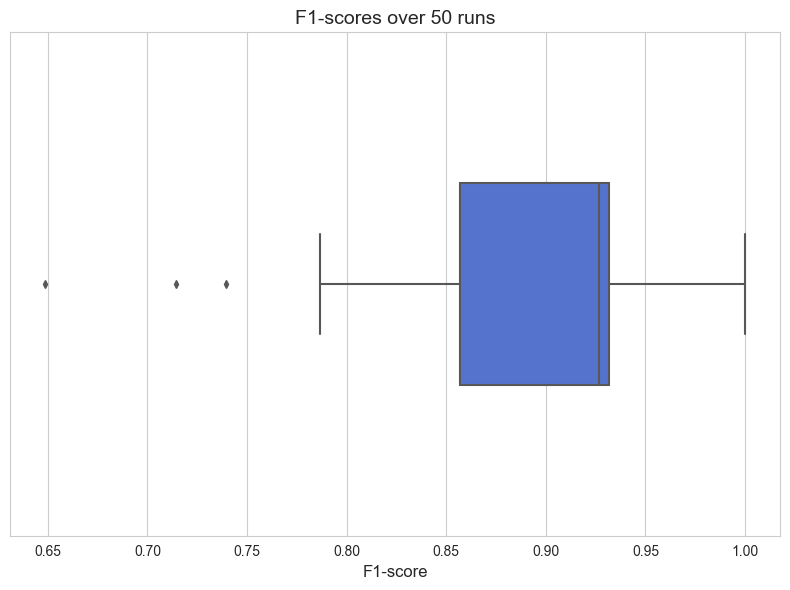

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the hyperparameters to search over
param_grid = {
    'svm__C': np.logspace(-3, 3, 7),
    'svm__gamma': ['scale', 'auto'] + list(np.logspace(-4, 2, 7))
}

# Create a pipeline with feature extraction, normalization, and model training steps
pipeline = Pipeline([
    ('vectorizer', DictVectorizer(sparse=False)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', random_state=42))
])

# Use a stratified KFold cross-validation for better model evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []

# To keep track of the best 5 models
best_models = []
best_scores = []

for i in range(50):
    print(f"Run {i+1}/50")
    # Split data into training and testing sets randomly
    X_train, X_test, y_train, y_test = train_test_split(data['feature_counts'], data['class_label'], test_size=0.2, random_state=i)

    # Perform a grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Train the SVM with the best hyperparameters found by the grid search
    clf = grid_search.best_estimator_

    # Make predictions on the testing set
    y_pred_test = clf.predict(X_test)

    # Evaluate the model on testing set
    f1_score_test = classification_report(y_test, y_pred_test, output_dict=True)['weighted avg']['f1-score']

    f1_scores.append(f1_score_test)

    print(f"F1-score on testing set: {f1_score_test:.3f}")
    print(f"Best hyperparameters found by grid search: {grid_search.best_params_}")
    print()
    
    # Update the best 5 models
    if len(best_models) < 5 or f1_score_test > min(best_scores):
        if len(best_models) == 5:
            idx_min_score = best_scores.index(min(best_scores))
            best_models.pop(idx_min_score)
            best_scores.pop(idx_min_score)

        best_models.append(clf)
        best_scores.append(f1_score_test)
        # Save the model
        with open(f"best_model_{len(best_models)}.pkl", "wb") as f:
            pickle.dump(clf, f)

# Plot the F1-scores over the 50 runs as a box plot
sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
sns.boxplot(x=f1_scores, color='royalblue', width=0.4, fliersize=4)
plt.title('F1-scores over 50 runs', fontsize=14)
plt.xlabel('F1-score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
